### Step 00: Getting Started 
**Business Problem**:

**Notebook Instruction**: 
The notebook requires you to import a set of built-in and third-party libraries as seen in the "import library" section below. If any of the packages is missing, please install the missing package via pip o conda. (Personally I prefer conda)

**Contact**:
If you have any question, email Waldo V (Data Scientist): panditas.datascientist@gmail.com

In [25]:
'''Main libraries'''
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import os, sys
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
from matplotlib.ticker import MultipleLocator
import seaborn as sns

'''Local functions'''
project_path = os.path.abspath('../')
sys.path.append(project_path)
from models.functions import (load_dataset, 
    wide_to_long, map_dates)

'''Data prep'''
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import confusion_matrix, classification_report

'''Algorithms'''
# import xgboost as xgb
# import xgboost as xgb

'Algorithms'

### Step 01: Data Cleaning
- Reshape dataframe: from wide to long format
- Summarize units sold by store, sku, and weekly
- Assign real weekly dates

In [27]:
# loading csv
df_sales = load_dataset('../data/product_sales_dataset_weekly.csv')
print(df_sales.head())

    Scode Pcode    Price  Wk0  Wk1  Wk2  Wk3  Wk4  Wk5  Wk6  ...  Wk96  Wk97  \
0  Store1  SKU1  $24.00    23   48   47   42   22   29   47  ...    33    40   
1  Store1  SKU2  $63.00    23   22   25   40   32   26   30  ...    25    50   
2  Store1  SKU3  $93.00     7   11    8    9   10    8    7  ...    13    30   
3  Store1  SKU4  $48.00    50   31   50   33   26   27   42  ...    26    23   
4  Store1  SKU5  $62.00     8    5   13   11    6    7    9  ...    15    21   

   Wk98  Wk99  Wk100  Wk101  Wk102  Wk103  Unnamed: 107  94  
0   125   133    229    381     21     31           NaN NaN  
1    75    95    231    590     25     33           NaN NaN  
2    67   188    267    330     35     33           NaN NaN  
3    92   126    205    357     30     34           NaN NaN  
4    93   243    710   1872     33     10           NaN NaN  

[5 rows x 109 columns]


In [28]:
# reshape dataframe: From wide to long dataframe 
df = wide_to_long(df_sales)
# summarize dataframe: The df has different prices for some values ['weekly', 'store', 'price'], and for 
# the first iteration, we'll omit price column
df = df.groupby(['store','item','weekly'], as_index=False )['units'].sum()
# assign real dates: map weekly columns to real dates
df['weekly_date'] = df['weekly'].apply(map_dates)

In [29]:
print(df.head())

    store  item weekly  units weekly_date
0  Store1  SKU1    Wk0     23  2023-01-07
1  Store1  SKU1    Wk1     48  2023-01-14
2  Store1  SKU1   Wk10     27  2023-03-18
3  Store1  SKU1  Wk100    229  2024-12-07
4  Store1  SKU1  Wk101    381  2024-12-14


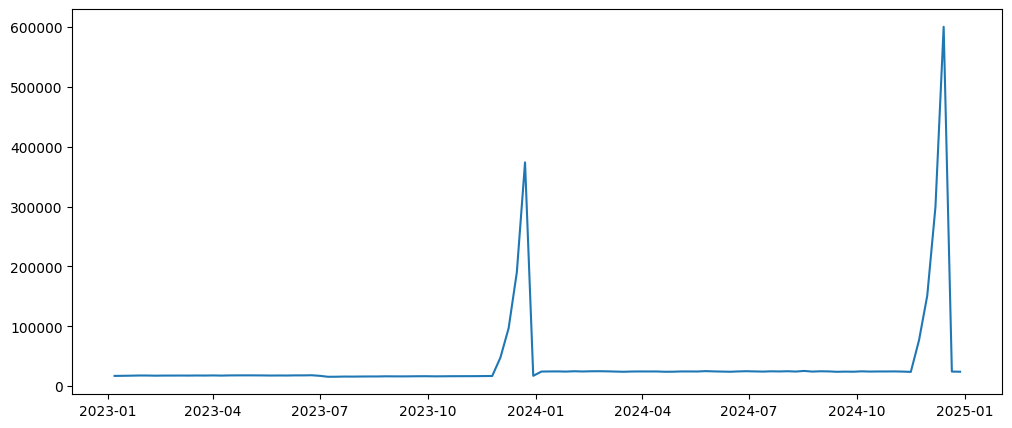

In [30]:
# copy df dataframe as df_viz
df_viz = df.copy()
df_viz = df_viz.groupby(['weekly_date', 'store'], as_index=False)['units'].sum()
df_viz = df_viz.set_index('weekly_date')
# set the color palette
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(df_viz[df_viz['store'] == 'Store1'].index, df_viz[df_viz['store'] == 'Store1']['units'])

plt.show()